# W2-r-localized cell

[GMM] Added .sample(n, seed) method.

=== Model: Regular 3×3 ===
  [β=0.1] full W2^2 ≈ 0.002768; best r-localized W2^2 ≈ 0.0004639 at r≈0.2
  [β=0.5] full W2^2 ≈ 0.00278; best r-localized W2^2 ≈ 0.0004496 at r≈0.293
  [β=1] full W2^2 ≈ 0.002748; best r-localized W2^2 ≈ 0.0003709 at r≈0.293
  [β=2] full W2^2 ≈ 0.001825; best r-localized W2^2 ≈ 0.0003112 at r≈0.2
  [β=5] full W2^2 ≈ 0.003786; best r-localized W2^2 ≈ 0.0004014 at r≈0.293
  [β=10] full W2^2 ≈ 0.00332; best r-localized W2^2 ≈ 0.0003704 at r≈0.2
[saved] tables/r_localized_W2_constbeta_Regular_3×3.csv

=== Model: Perturbed A ===
  [β=0.1] full W2^2 ≈ 0.02806; best r-localized W2^2 ≈ 0.001037 at r≈0.293
  [β=0.5] full W2^2 ≈ 0.01944; best r-localized W2^2 ≈ 0.0007381 at r≈0.2
  [β=1] full W2^2 ≈ 0.02242; best r-localized W2^2 ≈ 0.001145 at r≈0.293
  [β=2] full W2^2 ≈ 0.02469; best r-localized W2^2 ≈ 0.001132 at r≈0.2
  [β=5] full W2^2 ≈ 0.01408; best r-localized W2^2 ≈ 0.0009054 at r≈0.2
  [β=10] full W2^2 ≈ 0.01516; best r-lo

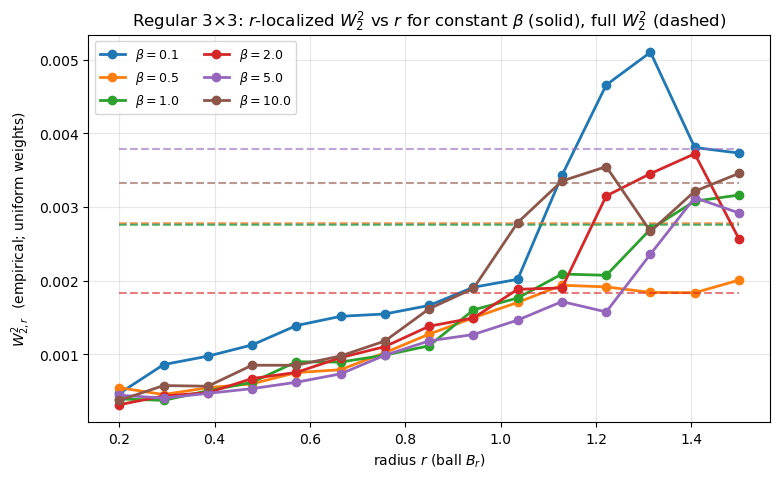

[saved] figs/r_localized_W2_vs_r_constbeta_Regular_3×3.png


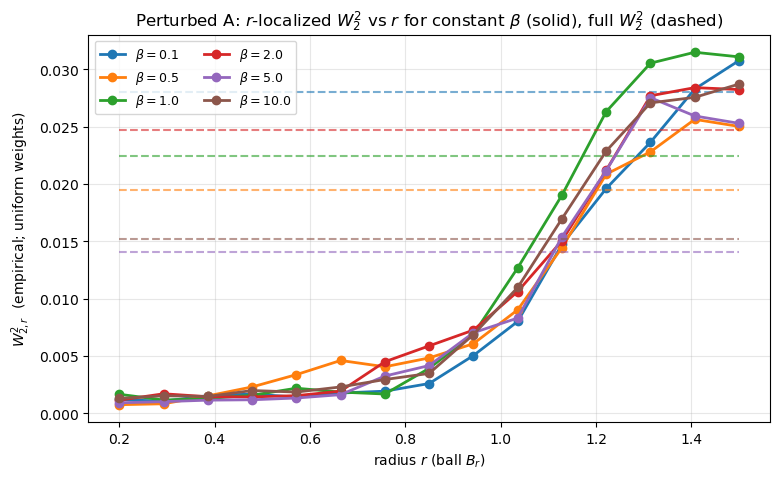

[saved] figs/r_localized_W2_vs_r_constbeta_Perturbed_A.png


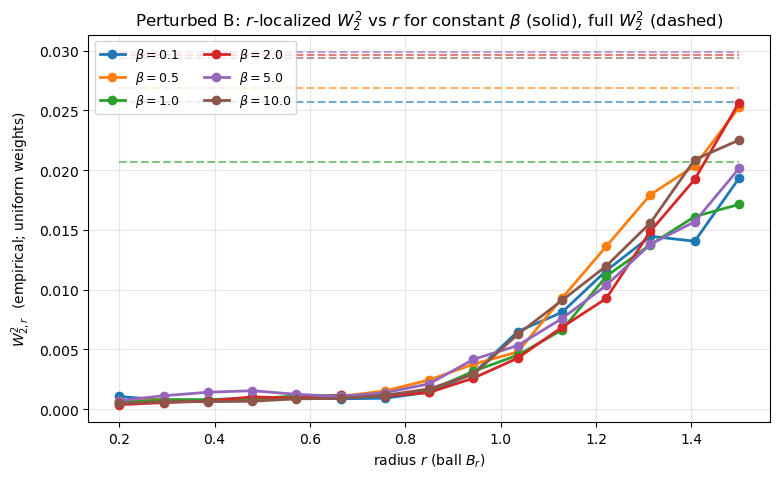

[saved] figs/r_localized_W2_vs_r_constbeta_Perturbed_B.png


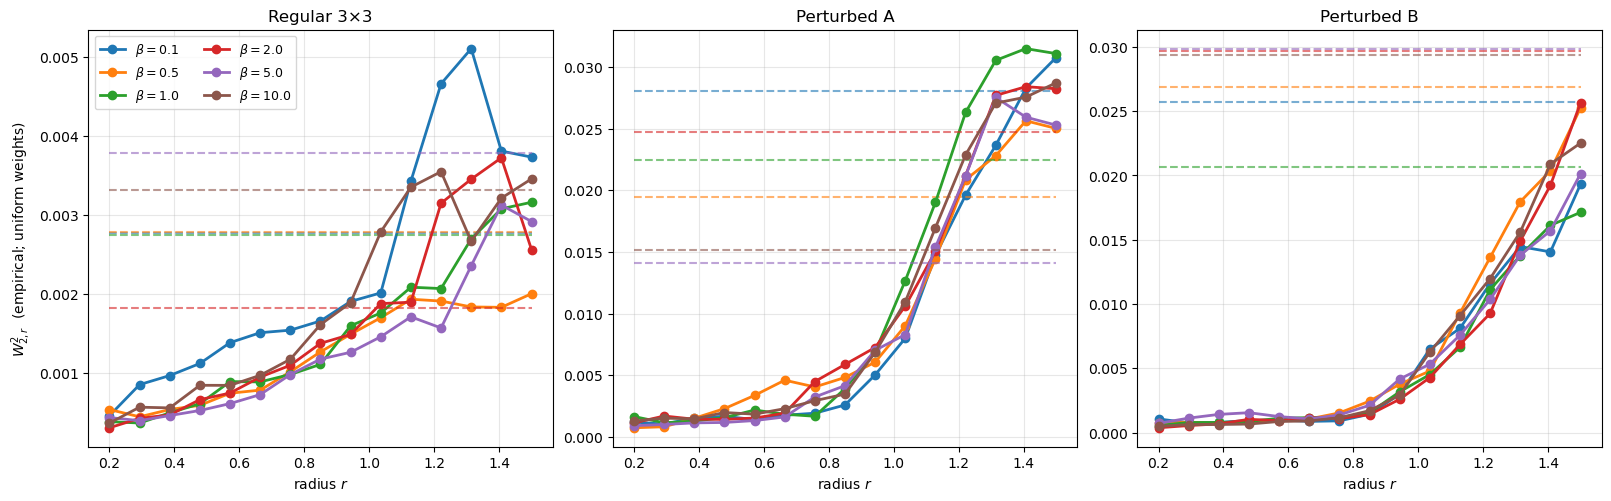

[saved] figs/r_localized_W2_vs_r_constbeta_3models.png


In [2]:
import sys
#sys.path.append('/mnt/data')
from ada_api_clean import *


# =======================================================
# r-localized Wasserstein study for constant-β schedules
#   • Models: Regular 3×3, Perturbed A, Perturbed B
#   • For each model and β, computes:
#       - W2^2 over the full support (dashed)
#       - r-localized W2^2 over a grid of radii r (solid)
#   • Outputs:
#       - Per-model plot  → figs/r_localized_W2_vs_r_constbeta_<model>.png
#       - Combined 1×3 grid → figs/r_localized_W2_vs_r_constbeta_3models.png
#       - Per-model CSV tables → tables/r_localized_W2_constbeta_<model>.csv
#
# Requires (already in your notebook):
#   - GMM(MU, SIG, PI), sample_gmm(gmm, M, rng)
#   - yhat_oracle_gmm(X, t, sched, gmm)
#   - BetaSchedulePWC.constant(...)
#   - alpha_K_gamma_from_schedule(sched, t)
# =======================================================
import numpy as np, math, os, csv
import matplotlib.pyplot as plt

os.makedirs("figs", exist_ok=True)
os.makedirs("tables", exist_ok=True)

# --------- utilities: simulation to terminal, norms, CRN sampling ----------
def simulate_terminal_const_beta(beta, gmm, *, M=3000, T=1200, seed=0, t_floor=0.01):
    rng  = np.random.default_rng(seed)
    dt   = 1.0 / T
    d    = gmm.d
    X    = np.zeros((M, d), float)   # start at 0 for stability/consistency

    sched = BetaSchedulePWC.constant(float(beta))
    _ = alpha_K_gamma_from_schedule(sched, 0.5)   # interior health probe

    for n in range(T):
        t_mid = (n + 0.5)/T
        t_eff = min(max(t_mid, float(t_floor)), 1.0 - float(t_floor))

        yhat = yhat_oracle_gmm(X, float(t_eff), sched, gmm)
        a_m  = float(sched.a_minus(float(t_eff)))
        b_m  = float(sched.b_minus(float(t_eff)))
        u    = b_m * yhat - a_m * X

        dW = rng.normal(size=X.shape) * math.sqrt(dt)
        X  = X + u*dt + dW

    return X

def euclid2(X):
    return np.sum(X*X, axis=1)

# --------- OT core: exact (Hungarian) if available; else Sinkhorn ----------
def _wasserstein2_exact(X, Y):
    """Exact W2 via Hungarian if SciPy is available; else raise."""
    try:
        from scipy.optimize import linear_sum_assignment
    except Exception:
        raise RuntimeError("SciPy not available for exact OT; use method='sinkhorn'.")
    C = np.sum((X[:,None,:] - Y[None,:,:])**2, axis=2)  # (K,K)
    r,c = linear_sum_assignment(C)
    return float(np.mean(C[r,c]))

def _sinkhorn_w2(X, Y, reg=0.02, n_iter=400, tol=1e-6):
    """
    Entropic OT (uniform marginals) returning <C, P*> ; for quadratic cost this
    is an upper bound on W2^2 as reg>0. Good enough for comparisons.
    """
    K = X.shape[0]
    C = np.sum((X[:,None,:] - Y[None,:,:])**2, axis=2)      # (K,K)
    Kmat = np.exp(-C / max(reg,1e-8)) + 1e-300              # Gibbs kernel
    u = np.ones(K)/K; v = np.ones(K)/K
    a = np.ones(K)/K; b = np.ones(K)/K

    for _ in range(n_iter):
        u_prev = u
        u = a / (Kmat @ v + 1e-300)
        v = b / (Kmat.T @ u + 1e-300)
        if np.max(np.abs(u - u_prev)) < tol:
            break
    P = (u[:,None] * Kmat) * v[None,:]                      # coupling
    return float(np.sum(P * C))

def wasserstein2_empirical(X, Y, method="auto", reg=0.02):
    """
    Returns W2^2 between two equally sized sets (uniform weights).
    method: 'auto' (exact if possible else sinkhorn), 'exact', or 'sinkhorn'
    """
    X = np.asarray(X, float); Y = np.asarray(Y, float)
    assert X.shape == Y.shape and X.ndim == 2
    if method == "exact":
        return _wasserstein2_exact(X, Y)
    if method == "sinkhorn":
        return _sinkhorn_w2(X, Y, reg=reg)
    # auto
    try:
        return _wasserstein2_exact(X, Y)
    except Exception:
        return _sinkhorn_w2(X, Y, reg=reg)

# --------- r-localized W2 driver ----------
def r_localized_w2_for_beta(
    beta, gmm, *, radii, M_sim=3000, T_sim=1200, seed=0, M_tar=6000,
    method="auto", reg=0.02, minK=50
):
    """
    Simulate AdaPID terminal X for a constant β; sample a CRN target Y; compute:
      • full W2 (all points; uses K=min(M_sim, M_tar))
      • r-localized W2 on B_r for each r in radii
    Returns dict with arrays 'r', 'W2r', 'W2full', plus counts per r.
    """
    # CRN
    rngY = np.random.default_rng(seed + 29)

    # Simulate terminal AdaPID
    X = simulate_terminal_const_beta(beta, gmm, M=M_sim, T=T_sim, seed=seed+101)
    # Target samples
    Y, _ = sample_gmm(gmm, M_tar, rngY)

    dX2 = euclid2(X); dY2 = euclid2(Y)

    # full (no radius filter)
    K_full = min(len(X), len(Y))
    idxX_full = np.arange(K_full)
    idxY_full = rngY.choice(len(Y), size=K_full, replace=False)
    W2_full = wasserstein2_empirical(X[idxX_full], Y[idxY_full], method=method, reg=reg)

    # per-radius localized
    W2r = []; nX_r = []; nY_r = []; K_used = []
    for r in radii:
        maskX = dX2 <= r*r
        maskY = dY2 <= r*r
        NX = int(np.sum(maskX)); NY = int(np.sum(maskY))
        nX_r.append(NX); nY_r.append(NY)
        if min(NX, NY) < minK:
            W2r.append(np.nan); K_used.append(0); continue
        K = min(NX, NY); K_used.append(K)
        idxX = np.flatnonzero(maskX)[:K]
        poolY = np.flatnonzero(maskY)
        idxY = rngY.choice(poolY, size=K, replace=False)
        W2r.append( wasserstein2_empirical(X[idxX], Y[idxY], method=method, reg=reg) )

    return dict(
        r=np.asarray(radii, float),
        W2r=np.asarray(W2r, float),
        W2full=float(W2_full),
        nX=np.asarray(nX_r, int),
        nY=np.asarray(nY_r, int),
        K=np.asarray(K_used, int),
        beta=float(beta)
    )

# -------------------- Build / reuse targets: three models --------------------
def build_regular_grid_gmm(a=1.5, sigma=0.3):
    xs = np.array([-a, 0.0, a], float)
    MU  = np.array([[xi, yj] for yj in xs for xi in xs], float)
    SIG = np.full(9, float(sigma))
    PI  = np.ones(9, float)/9.0
    return GMM(MU, SIG, PI)

def build_perturbed_gmm(seed, a=1.5, base_sigma=0.3,
                        jitter_frac=1/3, sig_scale=(0.5, 2.0),
                        weight_range=(0.5, 1.5)):
    rng = np.random.default_rng(int(seed))
    xs = np.array([-a, 0.0, a], float)
    centers = np.array([[xi, yj] for yj in xs for xi in xs], float)
    jitter_max = a * float(jitter_frac)
    MU  = centers + rng.uniform(-jitter_max, jitter_max, size=centers.shape)
    SIG = base_sigma * rng.uniform(sig_scale[0], sig_scale[1], size=9)
    w   = rng.uniform(weight_range[0], weight_range[1], size=9)
    PI  = w / np.sum(w)
    return GMM(MU, SIG, PI)

try:
    _ = gmm  # if a global gmm exists, fine—we build our own set below anyway
except NameError:
    pass

regular = build_regular_grid_gmm(a=1.5, sigma=0.3)
pertA   = build_perturbed_gmm(seed=20241005, a=1.5, base_sigma=0.3)
pertB   = build_perturbed_gmm(seed=20241006, a=1.5, base_sigma=0.3)
models  = [("Regular 3×3", regular), ("Perturbed A", pertA), ("Perturbed B", pertB)]

# -------------------- Settings: β’s and radii --------------------
beta_list = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]    # constant-β schedules
radii     = np.linspace(0.2, 1.5, 15)          # inner-to-outer balls

M_sim, T_sim = 20000, 2000
M_tar        = 20000
REG_OT       = 0.02
MIN_INBALL   = 80
SEED_BASE    = 20251011

# -------------------- Run for all three models --------------------
all_results = {}  # name -> list of dicts (one per β)
for mi, (name, gmm_m) in enumerate(models):
    print(f"\n=== Model: {name} ===")
    res_list = []
    for i, b in enumerate(beta_list):
        out = r_localized_w2_for_beta(
            beta=b, gmm=gmm_m, radii=radii,
            M_sim=M_sim, T_sim=T_sim, seed=SEED_BASE + 97*i + 1000*mi,
            M_tar=M_tar, method="auto", reg=REG_OT, minK=MIN_INBALL
        )
        res_list.append(out)
        print(f"  [β={b:.3g}] full W2^2 ≈ {out['W2full']:.4g}; "
              f"best r-localized W2^2 ≈ {np.nanmin(out['W2r']):.4g} at r≈{out['r'][np.nanargmin(out['W2r'])]:.3g}")
    all_results[name] = res_list

    # save per-model CSV
    csv_path = f"tables/r_localized_W2_constbeta_{name.replace(' ','_')}.csv"
    with open(csv_path, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["beta", "r", "W2_r2", "K_in_ball", "W2_full"])
        for out in res_list:
            for r, w2r, K in zip(out["r"], out["W2r"], out["K"]):
                w.writerow([f"{out['beta']:.6g}", f"{r:.6g}", f"{w2r:.8g}", int(K), f"{out['W2full']:.8g}"])
    print("[saved]", csv_path)

# -------------------- Per-model figures --------------------
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for name in all_results:
    plt.figure(figsize=(7.9, 4.9))
    for i, out in enumerate(all_results[name]):
        c = colors[i % len(colors)]
        plt.plot(out["r"], out["W2r"], marker="o", lw=2.0, color=c,
                 label=r"$\beta={}$".format(out["beta"]))
        plt.hlines(out["W2full"], radii.min(), radii.max(), colors=c, linestyles="--", alpha=0.6)
    plt.xlabel(r"radius $r$ (ball $B_r$)")
    plt.ylabel(r"$W_{2,r}^2$  (empirical; uniform weights)")
    plt.title(f"{name}: $r$-localized $W_2^2$ vs $r$ for constant $\\beta$ (solid), full $W_2^2$ (dashed)")
    plt.grid(True, alpha=0.3)
    plt.legend(ncol=2, frameon=True, fontsize=9)
    fig_path = f"figs/r_localized_W2_vs_r_constbeta_{name.replace(' ','_')}.png"
    plt.tight_layout(); plt.savefig(fig_path, dpi=300, bbox_inches="tight"); plt.show()
    print("[saved]", fig_path)

# -------------------- Combined 1×3 figure (three models side-by-side) --------------------
fig, axs = plt.subplots(1, 3, figsize=(16.0, 4.9), constrained_layout=True)
for ax, (name, res_list) in zip(axs, all_results.items()):
    for i, out in enumerate(res_list):
        c = colors[i % len(colors)]
        ax.plot(out["r"], out["W2r"], marker="o", lw=2.0, color=c,
                label=r"$\beta={}$".format(out["beta"]) if ax is axs[0] else None)
        ax.hlines(out["W2full"], radii.min(), radii.max(), colors=c, linestyles="--", alpha=0.6)
    ax.set_title(name)
    ax.set_xlabel(r"radius $r$")
    ax.grid(True, alpha=0.3)
axs[0].set_ylabel(r"$W_{2,r}^2$  (empirical; uniform weights)")
axs[0].legend(ncol=2, frameon=True, fontsize=9, loc="upper left")
fig_path_all = "figs/r_localized_W2_vs_r_constbeta_3models.png"
fig.savefig(fig_path_all, dpi=300, bbox_inches="tight"); plt.show()
print("[saved]", fig_path_all)
